# Deep transfer learning tutorial
This notebook contains two popular paradigms of transfer learning: **Finetune** and **Domain adaptation**.
Since most of the codes are shared by them, we show how they work in just one single notebook.
I think that transfer learning and domain adaptation are both easy, and there's no need to create some library or packages for this simple purpose, which only makes things difficult.
The purpose of this note book is we **don't even need to install a library or package** to train a domain adaptation or finetune model.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Some imports.

In [1]:
import os
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import time
from torchvision import models
torch.cuda.set_device(0)

In [3]:
# !pip install torch
# !pip install torchvision


In [3]:
print(torch.cuda.is_available())

True


Set the dataset folder, batch size, number of classes, and domain name.

In [4]:
data_folder = '/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/Z. RA & Desertation/Codes/Dr_Niu/MMD/Office31'
# data_folder = '/content/drive/MyDrive/3. Narges/Dr_Niu/MMD/Office31'

batch_size = 32
n_class = 31
domain_src, domain_tar = 'amazon/images', 'webcam/images'

## Data load
Now, define a data loader function.

In [6]:
def load_data(root_path, domain, batch_size, phase):
    transform_dict = {
        'src': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ]),
        'tar': transforms.Compose(
        [transforms.Resize(224),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ])}
    data = datasets.ImageFolder(root=os.path.join(root_path, domain), transform=transform_dict[phase])
    data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=phase=='src', drop_last=phase=='tar', num_workers=4)
    return data_loader

Load the data using the above function to test it.

In [7]:
src_loader = load_data(data_folder, domain_src, batch_size, phase='src')
tar_loader = load_data(data_folder, domain_tar, batch_size, phase='tar')
print(f'Source data number: {len(src_loader.dataset)}')
print(f'Target data number: {len(tar_loader.dataset)}')

Source data number: 2817
Target data number: 795


In [8]:
class TransferModel(nn.Module):
    def __init__(self,
                base_model : str = 'resnet50',
                pretrain : bool = True,
                n_class : int = 31):
        super(TransferModel, self).__init__()
        self.base_model = base_model
        self.pretrain = pretrain
        self.n_class = n_class
        if self.base_model == 'resnet50':
            self.model = torchvision.models.resnet50(pretrained=True)
            n_features = self.model.fc.in_features
            fc = torch.nn.Linear(n_features, n_class)
            self.model.fc = fc
        else:
            # Use other models you like, such as vgg or alexnet
            pass
        self.model.fc.weight.data.normal_(0, 0.005)
        self.model.fc.bias.data.fill_(0.1)

    def forward(self, x):
        return self.model(x)

    def predict(self, x):
        return self.forward(x)

Now, we define a model and test it using a random tensor.

In [9]:
model = TransferModel().cuda()
RAND_TENSOR = torch.randn(1, 3, 224, 224).cuda()
output = model(RAND_TENSOR)
print(output)
print(output.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor([[ 1.5830e-01,  1.9674e-01,  6.2873e-03,  2.7459e-01, -6.8800e-02,
         -6.3619e-02,  1.3707e-01,  8.9416e-02,  2.8811e-03,  1.8485e-01,
          2.1946e-01, -7.7034e-02,  2.8242e-01,  1.5460e-01,  1.6121e-01,
          8.7993e-02,  2.2279e-01,  1.7875e-01,  1.5221e-01,  2.1973e-01,
          6.3968e-03,  1.2002e-02,  4.4685e-02,  2.3907e-01,  1.4153e-01,
          4.7575e-02, -3.2074e-02,  1.6099e-01,  9.3780e-02,  1.7516e-04,
          4.2566e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)
torch.Size([1, 31])


In [10]:
dataloaders = {'src': src_loader,
               'val': tar_loader,
               'tar': tar_loader}
n_epoch = 100
criterion = nn.CrossEntropyLoss()
early_stop = 20

In [11]:
def test(model, target_test_loader):
    model.eval()
    correct = 0
    len_target_dataset = len(target_test_loader.dataset)
    with torch.no_grad():
        for data, target in target_test_loader:
            data, target = data.cuda(), target.cuda()
            s_output = model.predict(data)
            pred = torch.max(s_output, 1)[1]
            correct += torch.sum(pred == target)
    acc = correct.double() / len(target_test_loader.dataset)
    return acc

## Domain adaptation
Now we are in domain adaptation.

## Logic for domain adaptation
The logic for domain adaptation is mostly similar to finetune, except that we must add a loss to the finetune model to **regularize the distribution discrepancy** between two domains.
Therefore, the most different parts are:
- Define some **loss function** to compute the distance (which is the main contribution of most existing DA papers)
- Define a new model class to use that loss function for **forward** pass.
- Write a slightly different script to train, since we have to take both **source data, source label, and target data**.

### Loss function
The most popular loss function for DA is **MMD (Maximum Mean Discrepancy)**. For comaprison, we also use another popular loss **CORAL (CORrelation ALignment)**. They are defined as follows.

#### MMD loss

In [12]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_type='rbf', kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss


#### CORAL loss

In [13]:
def CORAL(source, target):
    d = source.size(1)
    ns, nt = source.size(0), target.size(0)

    # source covariance
    tmp_s = torch.ones((1, ns)).cuda() @ source
    cs = (source.t() @ source - (tmp_s.t() @ tmp_s) / ns) / (ns - 1)

    # target covariance
    tmp_t = torch.ones((1, nt)).cuda() @ target
    ct = (target.t() @ target - (tmp_t.t() @ tmp_t) / nt) / (nt - 1)

    # frobenius norm
    loss = (cs - ct).pow(2).sum().sqrt()
    loss = loss / (4 * d * d)

    return loss

### Model
Now we use ResNet-50 again just like finetune. The difference is that we rewrite the ResNet-50 class to drop its last layer.

In [14]:
from torchvision import models
class ResNet50Fc(nn.Module):
    def __init__(self):
        super(ResNet50Fc, self).__init__()
        model_resnet50 = models.resnet50(pretrained=True)
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        self.__in_features = model_resnet50.fc.in_features

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

    def output_num(self):
        return self.__in_features

In [15]:
# Function to visualize the convolutional kernels
def visualize_kernels(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            kernels = module.weight.data.cpu().numpy()
            num_kernels = kernels.shape[0]
            fig, axs = plt.subplots(1, num_kernels, figsize=(10, 2))
            for i in range(num_kernels):
                kernel = kernels[i, 0, :, :]
                axs[i].imshow(kernel, cmap='gray')
                axs[i].axis('off')
            plt.show()

# Function to compute the entropy of convolutional layers
def compute_entropy(model):
    entropy_values = []
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            weights = module.weight.data
            flattened_weights = weights.flatten()
#             normalized_weights = torch.softmax(flattened_weights, dim=1)
#             entropy = -torch.sum(normalized_weights * torch.log2(normalized_weights + 1e-10), dim=1)
            normalized_weights = (flattened_weights - torch.min(flattened_weights)) / (
                torch.max(flattened_weights) - torch.min(flattened_weights)
            )
            bin_counts = torch.histc(normalized_weights, bins=10)
            probabilities = bin_counts / len(flattened_weights)
            entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10))  # Add a small constant to avoid log(0)
            entropy_values.append(torch.mean(entropy).item())
    return entropy_values

# Function to add noise to an image
def add_noise(image, noise_level):
    noise = torch.randn_like(image) * noise_level
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0.0, 1.0)
    return noisy_image

Now the main class for DA. We take ResNet-50 as its backbone, add a bottleneck layer and our own FC layer for classification.
Note the `adapt_loss` function. It is just using our predefined MMD or CORAL loss. Of course you can use your own loss.

In [16]:
class TransferNet(nn.Module):
    def __init__(self,
                 num_class,
                 base_net='resnet50',
                 transfer_loss='mmd',
                 use_bottleneck=True,
                 bottleneck_width=256,
                 width=1024):
        super(TransferNet, self).__init__()
        if base_net == 'resnet50':
            self.base_network = ResNet50Fc()
        else:
            # Your own basenet
            return
        self.use_bottleneck = use_bottleneck
        self.transfer_loss = transfer_loss
        bottleneck_list = [nn.Linear(self.base_network.output_num(
        ), bottleneck_width), nn.BatchNorm1d(bottleneck_width), nn.ReLU(), nn.Dropout(0.5)]
        self.bottleneck_layer = nn.Sequential(*bottleneck_list)
        classifier_layer_list = [nn.Linear(self.base_network.output_num(), width), nn.ReLU(), nn.Dropout(0.5),
                                 nn.Linear(width, num_class)]
        self.classifier_layer = nn.Sequential(*classifier_layer_list)

        self.bottleneck_layer[0].weight.data.normal_(0, 0.005)
        self.bottleneck_layer[0].bias.data.fill_(0.1)
        for i in range(2):
            self.classifier_layer[i * 3].weight.data.normal_(0, 0.01)
            self.classifier_layer[i * 3].bias.data.fill_(0.0)

    def forward(self, source, target):
        source = self.base_network(source)
        target = self.base_network(target)
        source_clf = self.classifier_layer(source)
        if self.use_bottleneck:
            source = self.bottleneck_layer(source)
            target = self.bottleneck_layer(target)
        transfer_loss = self.adapt_loss(source, target, self.transfer_loss)
        return source_clf, transfer_loss

    def predict(self, x):
        features = self.base_network(x)
        clf = self.classifier_layer(features)
        return clf

    def adapt_loss(self, X, Y, adapt_loss):
        """Compute adaptation loss, currently we support mmd and coral

        Arguments:
            X {tensor} -- source matrix
            Y {tensor} -- target matrix
            adapt_loss {string} -- loss type, 'mmd' or 'coral'. You can add your own loss

        Returns:
            [tensor] -- adaptation loss tensor
        """
        if adapt_loss == 'mmd':
            mmd_loss = MMD_loss()
            loss = mmd_loss(X, Y)
        elif adapt_loss == 'coral':
            loss = CORAL(X, Y)
        else:
            # Your own loss
            loss = 0
        return loss

### Train
Now the train part.

In [17]:
transfer_loss = 'mmd'
learning_rate = 0.0001
transfer_model = TransferNet(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
optimizer = torch.optim.SGD([
    {'params': transfer_model.base_network.parameters()},
    {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
    {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
], lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# lamb = 0.5 # weight for transfer loss, it is a hyperparameter that needs to be tuned

The main train function. Since we have to enumerate all source and target samples, we have to use `zip` operation to enumerate each pair of these two domains. It is common that two domains have different sizes, but we think by randomly sampling them in many epochs, we may sample each one of them.

In [18]:
def train(dataloaders, model, optimizer):
    source_loader, target_train_loader, target_test_loader = dataloaders['src'], dataloaders['val'], dataloaders['tar']
    len_source_loader = len(source_loader)
    len_target_loader = len(target_train_loader)
    best_acc = 0
    stop = 0
    n_batch = min(len_source_loader, len_target_loader)
    for e in range(n_epoch):
        stop += 1
        train_loss_clf, train_loss_transfer, train_loss_total = 0, 0, 0
        model.train()
        for (src, tar) in zip(source_loader, target_train_loader):
            data_source, label_source = src
            data_target, _ = tar
            data_source, label_source = data_source.cuda(), label_source.cuda()
            data_target = data_target.cuda()

            optimizer.zero_grad()
            label_source_pred, transfer_loss = model(data_source, data_target)
            clf_loss = criterion(label_source_pred, label_source)
            loss = clf_loss + lamb * transfer_loss
            loss.backward()
            optimizer.step()
            train_loss_clf = clf_loss.detach().item() + train_loss_clf
            train_loss_transfer = transfer_loss.detach().item() + train_loss_transfer
            train_loss_total = loss.detach().item() + train_loss_total
        acc = test(model, target_test_loader)
        print(f'Epoch: [{e:2d}/{n_epoch}], cls_loss: {train_loss_clf/n_batch:.4f}, transfer_loss: {train_loss_transfer/n_batch:.4f}, total_Loss: {train_loss_total/n_batch:.4f}, acc: {acc:.4f}')

        if best_acc < acc:
            best_acc = acc
            torch.save(model.state_dict(), 'trans_model_webcam.pkl')
            stop = 0
        if stop >= early_stop:
            break

In [19]:
# train(dataloaders, transfer_model, optimizer)

In [20]:
# transfer_model.load_state_dict(torch.load('trans_model_webcam.pkl'))
# acc_test = test(transfer_model, dataloaders['tar'])
# print(f'Test accuracy: {acc_test}')

Now we are done.

You see, we don't even need to install a library or package to train a domain adaptation or finetune model.
In your own work, you can also use this notebook to test your own algorithms.

Add entropy

# Archive


In [21]:
def test2(model, target_test_loader, lamb):
    records = [] # new added
    model.eval()
    correct = 0
    len_target_dataset = len(target_test_loader.dataset)
    with torch.no_grad():
        for data, target in target_test_loader:
            data, target = data.cuda(), target.cuda()
            s_output = model.predict(data)
            pred = torch.max(s_output, 1)[1]
            correct += torch.sum(pred == target)
    acc = correct.double() / len(target_test_loader.dataset)
    records.append({ # new added
            'Lambda': lamb,
            'Test accuracy': acc,
    })
    global test_result
    test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
    return acc

In [22]:
import numpy as np
test_result = pd.DataFrame(columns=["lambda", "Test accuracy"])
train_result = pd.DataFrame()
test_result = pd.DataFrame()

import gc
train_result = pd.DataFrame() # new added
test_result = pd.DataFrame()
for lamb in np.arange(0, 1, 0.10):
    transfer_loss = 'mmd'
    learning_rate = 0.0001
    transfer_model = TransferNet(n_class, transfer_loss=transfer_loss, base_net='resnet50').cuda()
    optimizer = torch.optim.SGD([
        {'params': transfer_model.base_network.parameters()},
        {'params': transfer_model.bottleneck_layer.parameters(), 'lr': 10 * learning_rate},
        {'params': transfer_model.classifier_layer.parameters(), 'lr': 10 * learning_rate},
    ], lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    # lamb = 0.5 # weight for transfer loss, it is a hyperparameter that needs to be tuned

    # train_result = pd.DataFrame() # new added
    # test_result = pd.DataFrame()
    def train2(dataloaders, model, optimizer, lamb):
        source_loader, target_train_loader, target_test_loader = dataloaders['src'], dataloaders['val'], dataloaders['tar']
        len_source_loader = len(source_loader)
        len_target_loader = len(target_train_loader)
        best_acc = 0
        stop = 0
        n_batch = min(len_source_loader, len_target_loader)
        records = [] # new added
        for e in range(n_epoch):
            stop += 1
            train_loss_clf, train_loss_transfer, train_loss_total = 0, 0, 0
            model.train()
            for (src, tar) in zip(source_loader, target_train_loader):
                data_source, label_source = src
                data_target, _ = tar
                data_source, label_source = data_source.cuda(), label_source.cuda()
                data_target = data_target.cuda()

                optimizer.zero_grad()
                label_source_pred, transfer_loss = model(data_source, data_target)
                clf_loss = criterion(label_source_pred, label_source)
                loss = clf_loss + lamb * transfer_loss
                loss.backward()
                optimizer.step()
                train_loss_clf = clf_loss.detach().item() + train_loss_clf
                train_loss_transfer = transfer_loss.detach().item() + train_loss_transfer
                train_loss_total = loss.detach().item() + train_loss_total
            acc = test(model, target_test_loader)
            print(f'lambda= {lamb}',f'Epoch: [{e:2d}/{n_epoch}], cls_loss: {train_loss_clf/n_batch:.4f}, transfer_loss: {train_loss_transfer/n_batch:.4f}, total_Loss: {train_loss_total/n_batch:.4f}, acc: {acc:.4f}')
            records.append({ # new added
                'Lambda': lamb,
                'Epoch': e,
                'Cls_Loss': train_loss_clf/n_batch,
                'Transfer_Loss': train_loss_transfer/n_batch,
                'Total_Loss': train_loss_total/n_batch,
                'Accuracy': acc
            })

            if best_acc < acc:
                best_acc = acc
                torch.save(model.state_dict(), 'trans_model_webcam.pkl')
                stop = 0
            if stop >= early_stop:
                break

        global train_result
        train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
        train_result.to_csv(os.path.join(data_folder, f'train_result_amazon_webcam_resnet50_lambda {lamb}.csv'), index=False)

    train2(dataloaders, transfer_model, optimizer, lamb.round(1))
    transfer_model.load_state_dict(torch.load('trans_model_webcam.pkl'))
    acc_test = test2(transfer_model, dataloaders['tar'], lamb)
    print(f'lambda= {lamb}', f'Test accuracy: {acc_test}')
    del transfer_model
    # del train2


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


lambda= 0.0 Epoch: [ 0/100], cls_loss: 3.4290, transfer_loss: 0.1644, total_Loss: 3.4290, acc: 0.1396
lambda= 0.0 Epoch: [ 1/100], cls_loss: 3.3929, transfer_loss: 0.1620, total_Loss: 3.3929, acc: 0.1208
lambda= 0.0 Epoch: [ 2/100], cls_loss: 3.3592, transfer_loss: 0.1637, total_Loss: 3.3592, acc: 0.1824
lambda= 0.0 Epoch: [ 3/100], cls_loss: 3.3176, transfer_loss: 0.1642, total_Loss: 3.3176, acc: 0.1937
lambda= 0.0 Epoch: [ 4/100], cls_loss: 3.2749, transfer_loss: 0.1633, total_Loss: 3.2749, acc: 0.2377
lambda= 0.0 Epoch: [ 5/100], cls_loss: 3.2232, transfer_loss: 0.1630, total_Loss: 3.2232, acc: 0.3082
lambda= 0.0 Epoch: [ 6/100], cls_loss: 3.1685, transfer_loss: 0.1622, total_Loss: 3.1685, acc: 0.3233
lambda= 0.0 Epoch: [ 7/100], cls_loss: 3.0962, transfer_loss: 0.1626, total_Loss: 3.0962, acc: 0.4025
lambda= 0.0 Epoch: [ 8/100], cls_loss: 3.0235, transfer_loss: 0.1634, total_Loss: 3.0235, acc: 0.4226
lambda= 0.0 Epoch: [ 9/100], cls_loss: 2.9208, transfer_loss: 0.1625, total_Loss: 

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.0 Test accuracy: 0.7496855345911949
lambda= 0.1 Epoch: [ 0/100], cls_loss: 3.4265, transfer_loss: 0.1635, total_Loss: 3.4429, acc: 0.0616
lambda= 0.1 Epoch: [ 1/100], cls_loss: 3.3976, transfer_loss: 0.1621, total_Loss: 3.4138, acc: 0.1132
lambda= 0.1 Epoch: [ 2/100], cls_loss: 3.3623, transfer_loss: 0.1629, total_Loss: 3.3786, acc: 0.1145
lambda= 0.1 Epoch: [ 3/100], cls_loss: 3.3391, transfer_loss: 0.1641, total_Loss: 3.3555, acc: 0.1962
lambda= 0.1 Epoch: [ 4/100], cls_loss: 3.2901, transfer_loss: 0.1644, total_Loss: 3.3065, acc: 0.2277
lambda= 0.1 Epoch: [ 5/100], cls_loss: 3.2423, transfer_loss: 0.1628, total_Loss: 3.2586, acc: 0.2453
lambda= 0.1 Epoch: [ 6/100], cls_loss: 3.1920, transfer_loss: 0.1632, total_Loss: 3.2084, acc: 0.3648
lambda= 0.1 Epoch: [ 7/100], cls_loss: 3.1315, transfer_loss: 0.1646, total_Loss: 3.1479, acc: 0.3950
lambda= 0.1 Epoch: [ 8/100], cls_loss: 3.0678, transfer_loss: 0.1638, total_Loss: 3.0842, acc: 0.3736
lambda= 0.1 Epoch: [ 9/100], cls_los

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.1 Test accuracy: 0.7371069182389937
lambda= 0.2 Epoch: [ 0/100], cls_loss: 3.4311, transfer_loss: 0.1633, total_Loss: 3.4638, acc: 0.0289
lambda= 0.2 Epoch: [ 1/100], cls_loss: 3.4016, transfer_loss: 0.1646, total_Loss: 3.4345, acc: 0.1409
lambda= 0.2 Epoch: [ 2/100], cls_loss: 3.3596, transfer_loss: 0.1629, total_Loss: 3.3922, acc: 0.1358
lambda= 0.2 Epoch: [ 3/100], cls_loss: 3.3345, transfer_loss: 0.1637, total_Loss: 3.3673, acc: 0.0742
lambda= 0.2 Epoch: [ 4/100], cls_loss: 3.2824, transfer_loss: 0.1636, total_Loss: 3.3151, acc: 0.1648
lambda= 0.2 Epoch: [ 5/100], cls_loss: 3.2462, transfer_loss: 0.1635, total_Loss: 3.2789, acc: 0.2528
lambda= 0.2 Epoch: [ 6/100], cls_loss: 3.1894, transfer_loss: 0.1640, total_Loss: 3.2222, acc: 0.3874
lambda= 0.2 Epoch: [ 7/100], cls_loss: 3.1195, transfer_loss: 0.1650, total_Loss: 3.1525, acc: 0.4893
lambda= 0.2 Epoch: [ 8/100], cls_loss: 3.0435, transfer_loss: 0.1645, total_Loss: 3.0764, acc: 0.4126
lambda= 0.2 Epoch: [ 9/100], cls_los

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.2 Test accuracy: 0.7647798742138364
lambda= 0.3 Epoch: [ 0/100], cls_loss: 3.4286, transfer_loss: 0.1618, total_Loss: 3.4771, acc: 0.0679
lambda= 0.3 Epoch: [ 1/100], cls_loss: 3.3928, transfer_loss: 0.1627, total_Loss: 3.4416, acc: 0.0881
lambda= 0.3 Epoch: [ 2/100], cls_loss: 3.3592, transfer_loss: 0.1621, total_Loss: 3.4078, acc: 0.1094
lambda= 0.3 Epoch: [ 3/100], cls_loss: 3.3235, transfer_loss: 0.1629, total_Loss: 3.3724, acc: 0.1723
lambda= 0.3 Epoch: [ 4/100], cls_loss: 3.2814, transfer_loss: 0.1633, total_Loss: 3.3304, acc: 0.2717
lambda= 0.3 Epoch: [ 5/100], cls_loss: 3.2460, transfer_loss: 0.1635, total_Loss: 3.2951, acc: 0.3245
lambda= 0.3 Epoch: [ 6/100], cls_loss: 3.1749, transfer_loss: 0.1613, total_Loss: 3.2233, acc: 0.3497
lambda= 0.3 Epoch: [ 7/100], cls_loss: 3.1142, transfer_loss: 0.1626, total_Loss: 3.1630, acc: 0.3786
lambda= 0.3 Epoch: [ 8/100], cls_loss: 3.0612, transfer_loss: 0.1638, total_Loss: 3.1103, acc: 0.4164
lambda= 0.3 Epoch: [ 9/100], cls_los

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.30000000000000004 Test accuracy: 0.750943396226415
lambda= 0.4 Epoch: [ 0/100], cls_loss: 3.4274, transfer_loss: 0.1635, total_Loss: 3.4928, acc: 0.0755
lambda= 0.4 Epoch: [ 1/100], cls_loss: 3.3949, transfer_loss: 0.1641, total_Loss: 3.4605, acc: 0.1346
lambda= 0.4 Epoch: [ 2/100], cls_loss: 3.3578, transfer_loss: 0.1635, total_Loss: 3.4232, acc: 0.1874
lambda= 0.4 Epoch: [ 3/100], cls_loss: 3.3342, transfer_loss: 0.1612, total_Loss: 3.3987, acc: 0.2289
lambda= 0.4 Epoch: [ 4/100], cls_loss: 3.2863, transfer_loss: 0.1637, total_Loss: 3.3518, acc: 0.2717
lambda= 0.4 Epoch: [ 5/100], cls_loss: 3.2314, transfer_loss: 0.1638, total_Loss: 3.2969, acc: 0.3774
lambda= 0.4 Epoch: [ 6/100], cls_loss: 3.1831, transfer_loss: 0.1621, total_Loss: 3.2480, acc: 0.4226
lambda= 0.4 Epoch: [ 7/100], cls_loss: 3.1173, transfer_loss: 0.1628, total_Loss: 3.1824, acc: 0.4755
lambda= 0.4 Epoch: [ 8/100], cls_loss: 3.0494, transfer_loss: 0.1632, total_Loss: 3.1147, acc: 0.4579
lambda= 0.4 Epoch: [ 

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.4 Test accuracy: 0.7496855345911949
lambda= 0.5 Epoch: [ 0/100], cls_loss: 3.4237, transfer_loss: 0.1644, total_Loss: 3.5059, acc: 0.0553
lambda= 0.5 Epoch: [ 1/100], cls_loss: 3.3938, transfer_loss: 0.1616, total_Loss: 3.4746, acc: 0.0717
lambda= 0.5 Epoch: [ 2/100], cls_loss: 3.3543, transfer_loss: 0.1629, total_Loss: 3.4358, acc: 0.1535
lambda= 0.5 Epoch: [ 3/100], cls_loss: 3.3259, transfer_loss: 0.1646, total_Loss: 3.4082, acc: 0.2025
lambda= 0.5 Epoch: [ 4/100], cls_loss: 3.2826, transfer_loss: 0.1633, total_Loss: 3.3642, acc: 0.2893
lambda= 0.5 Epoch: [ 5/100], cls_loss: 3.2320, transfer_loss: 0.1630, total_Loss: 3.3135, acc: 0.3660
lambda= 0.5 Epoch: [ 6/100], cls_loss: 3.1891, transfer_loss: 0.1623, total_Loss: 3.2703, acc: 0.3711
lambda= 0.5 Epoch: [ 7/100], cls_loss: 3.1025, transfer_loss: 0.1618, total_Loss: 3.1834, acc: 0.4239
lambda= 0.5 Epoch: [ 8/100], cls_loss: 3.0452, transfer_loss: 0.1640, total_Loss: 3.1272, acc: 0.4453
lambda= 0.5 Epoch: [ 9/100], cls_los

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.5 Test accuracy: 0.7459119496855345
lambda= 0.6 Epoch: [ 0/100], cls_loss: 3.4286, transfer_loss: 0.1642, total_Loss: 3.5271, acc: 0.0541
lambda= 0.6 Epoch: [ 1/100], cls_loss: 3.4009, transfer_loss: 0.1627, total_Loss: 3.4985, acc: 0.0767
lambda= 0.6 Epoch: [ 2/100], cls_loss: 3.3657, transfer_loss: 0.1650, total_Loss: 3.4647, acc: 0.0277
lambda= 0.6 Epoch: [ 3/100], cls_loss: 3.3393, transfer_loss: 0.1641, total_Loss: 3.4378, acc: 0.2000
lambda= 0.6 Epoch: [ 4/100], cls_loss: 3.2865, transfer_loss: 0.1632, total_Loss: 3.3845, acc: 0.2101
lambda= 0.6 Epoch: [ 5/100], cls_loss: 3.2394, transfer_loss: 0.1636, total_Loss: 3.3376, acc: 0.2038
lambda= 0.6 Epoch: [ 6/100], cls_loss: 3.1827, transfer_loss: 0.1631, total_Loss: 3.2805, acc: 0.3899
lambda= 0.6 Epoch: [ 7/100], cls_loss: 3.1461, transfer_loss: 0.1646, total_Loss: 3.2449, acc: 0.3711
lambda= 0.6 Epoch: [ 8/100], cls_loss: 3.0601, transfer_loss: 0.1630, total_Loss: 3.1580, acc: 0.5296
lambda= 0.6 Epoch: [ 9/100], cls_los

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.6000000000000001 Test accuracy: 0.7471698113207547
lambda= 0.7 Epoch: [ 0/100], cls_loss: 3.4306, transfer_loss: 0.1621, total_Loss: 3.5441, acc: 0.0818
lambda= 0.7 Epoch: [ 1/100], cls_loss: 3.4009, transfer_loss: 0.1621, total_Loss: 3.5144, acc: 0.1245
lambda= 0.7 Epoch: [ 2/100], cls_loss: 3.3641, transfer_loss: 0.1637, total_Loss: 3.4787, acc: 0.1371
lambda= 0.7 Epoch: [ 3/100], cls_loss: 3.3165, transfer_loss: 0.1637, total_Loss: 3.4311, acc: 0.2151
lambda= 0.7 Epoch: [ 4/100], cls_loss: 3.2835, transfer_loss: 0.1638, total_Loss: 3.3982, acc: 0.2692
lambda= 0.7 Epoch: [ 5/100], cls_loss: 3.2407, transfer_loss: 0.1634, total_Loss: 3.3551, acc: 0.3811
lambda= 0.7 Epoch: [ 6/100], cls_loss: 3.1817, transfer_loss: 0.1630, total_Loss: 3.2958, acc: 0.3535
lambda= 0.7 Epoch: [ 7/100], cls_loss: 3.1139, transfer_loss: 0.1633, total_Loss: 3.2282, acc: 0.4440
lambda= 0.7 Epoch: [ 8/100], cls_loss: 3.0331, transfer_loss: 0.1625, total_Loss: 3.1469, acc: 0.4642
lambda= 0.7 Epoch: [ 

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.7000000000000001 Test accuracy: 0.740880503144654
lambda= 0.8 Epoch: [ 0/100], cls_loss: 3.4268, transfer_loss: 0.1628, total_Loss: 3.5570, acc: 0.0780
lambda= 0.8 Epoch: [ 1/100], cls_loss: 3.3929, transfer_loss: 0.1629, total_Loss: 3.5232, acc: 0.1686
lambda= 0.8 Epoch: [ 2/100], cls_loss: 3.3677, transfer_loss: 0.1624, total_Loss: 3.4977, acc: 0.2440
lambda= 0.8 Epoch: [ 3/100], cls_loss: 3.3267, transfer_loss: 0.1635, total_Loss: 3.4574, acc: 0.2289
lambda= 0.8 Epoch: [ 4/100], cls_loss: 3.2812, transfer_loss: 0.1634, total_Loss: 3.4120, acc: 0.1824
lambda= 0.8 Epoch: [ 5/100], cls_loss: 3.2420, transfer_loss: 0.1629, total_Loss: 3.3722, acc: 0.2855
lambda= 0.8 Epoch: [ 6/100], cls_loss: 3.1797, transfer_loss: 0.1627, total_Loss: 3.3098, acc: 0.3899
lambda= 0.8 Epoch: [ 7/100], cls_loss: 3.1210, transfer_loss: 0.1636, total_Loss: 3.2519, acc: 0.3849
lambda= 0.8 Epoch: [ 8/100], cls_loss: 3.0680, transfer_loss: 0.1631, total_Loss: 3.1985, acc: 0.4943
lambda= 0.8 Epoch: [ 9

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)
<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET

lambda= 0.8 Test accuracy: 0.7333333333333333
lambda= 0.9 Epoch: [ 0/100], cls_loss: 3.4265, transfer_loss: 0.1640, total_Loss: 3.5741, acc: 0.0491
lambda= 0.9 Epoch: [ 1/100], cls_loss: 3.3954, transfer_loss: 0.1629, total_Loss: 3.5420, acc: 0.1057
lambda= 0.9 Epoch: [ 2/100], cls_loss: 3.3588, transfer_loss: 0.1647, total_Loss: 3.5071, acc: 0.0994
lambda= 0.9 Epoch: [ 3/100], cls_loss: 3.3191, transfer_loss: 0.1635, total_Loss: 3.4662, acc: 0.1799
lambda= 0.9 Epoch: [ 4/100], cls_loss: 3.2731, transfer_loss: 0.1631, total_Loss: 3.4198, acc: 0.3333
lambda= 0.9 Epoch: [ 5/100], cls_loss: 3.2303, transfer_loss: 0.1636, total_Loss: 3.3775, acc: 0.3899
lambda= 0.9 Epoch: [ 6/100], cls_loss: 3.1908, transfer_loss: 0.1635, total_Loss: 3.3379, acc: 0.3736
lambda= 0.9 Epoch: [ 7/100], cls_loss: 3.1101, transfer_loss: 0.1630, total_Loss: 3.2568, acc: 0.4516
lambda= 0.9 Epoch: [ 8/100], cls_loss: 3.0470, transfer_loss: 0.1621, total_Loss: 3.1929, acc: 0.5409
lambda= 0.9 Epoch: [ 9/100], cls_los

<ipython-input-22-f33a8f85b166>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_result = train_result.append(pd.DataFrame(records), ignore_index=True)


lambda= 0.9 Test accuracy: 0.7383647798742138


<ipython-input-21-47478dc6ccbe>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_result = test_result.append(pd.DataFrame(records), ignore_index=True)


In [23]:
train_result.to_csv(os.path.join(data_folder, 'train_result_amazon_webcam_resnet50.csv'), index=False)
test_result.to_csv(os.path.join(data_folder, 'test_result_amazon_webcam_resnet50.csv'), index=False)

# Plots

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
data_folder = '/content/drive/MyDrive/4. BGSU/1.2 PhD_Courses/Z. RA & Desertation/Codes/Dr_Niu/MMD/Office31'
# df1 = pd.read_csv(os.path.join(data_folder, 'test_result_amazon_webcam_resnet50.csv'))
df_web = pd.read_csv(os.path.join(data_folder, 'test_train_result_amazon_webcam_resnet50.csv'))
df_dslr = pd.read_csv(os.path.join(data_folder, 'test_train_result_amazon_dslr_resnet50.csv'))


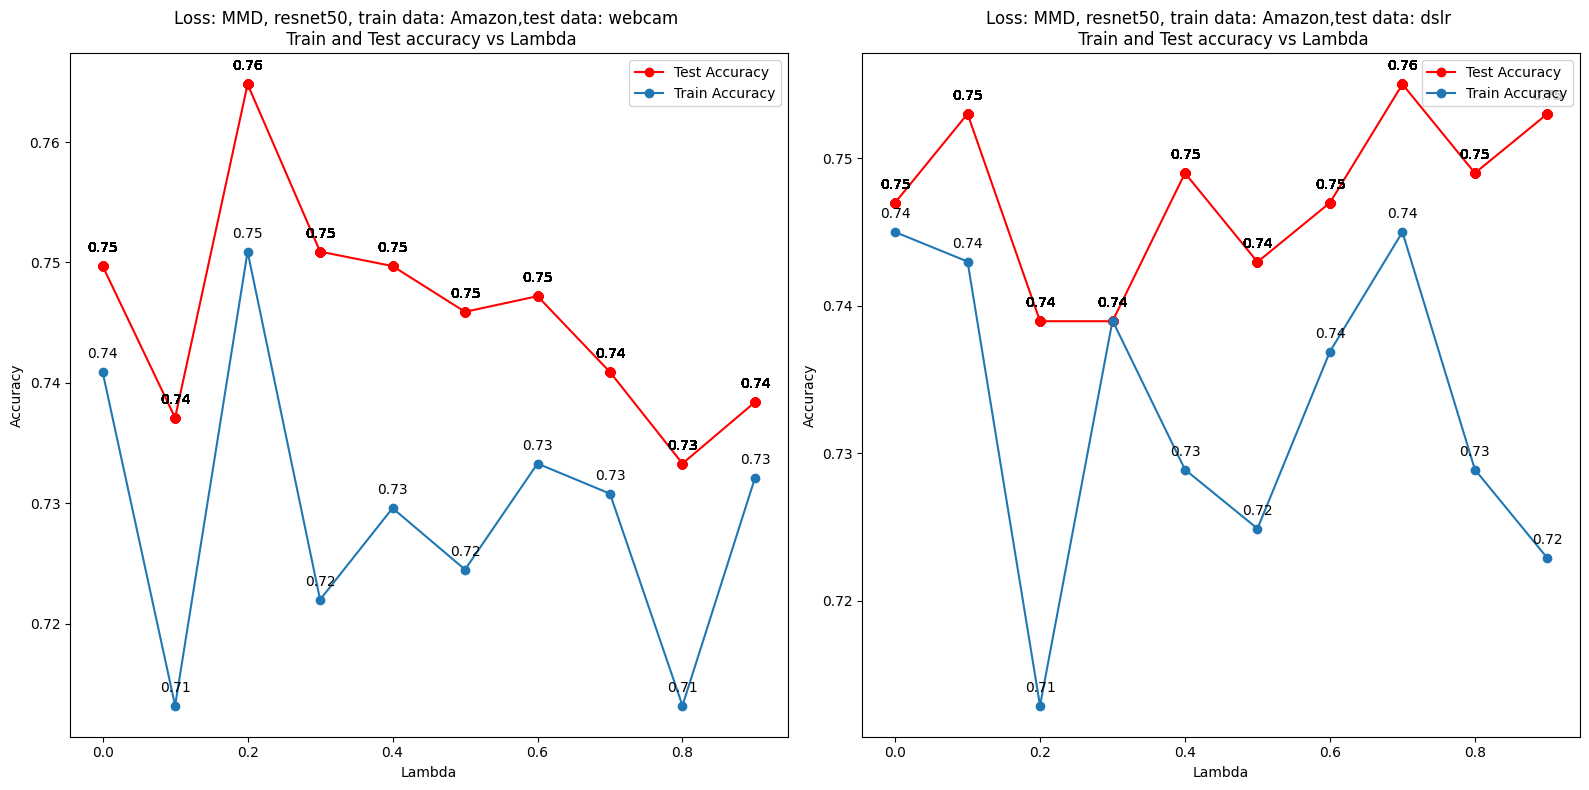

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].plot(df_web.Lambda, df_web['Test Accuracy'], 'ro-', label="Test Accuracy")
for x, y in zip(df_web.Lambda, df_web['Test Accuracy']):
    axes[0].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
axes[0].set_title("Loss: MMD, resnet50, train data: Amazon,test data: webcam \n Train and Test accuracy vs Lambda")
axes[0].set_xlabel("Lambda")
axes[0].set_ylabel("Accuracy")

y_values = df_web.groupby('Lambda')['Accuracy'].last()
axes[0].plot(df_web.Lambda.unique(), y_values, 'o-', label="Train Accuracy")
for x, y in zip(df_web.Lambda.unique(), y_values):
    axes[0].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

axes[0].legend()


axes[1].plot(df_dslr.Lambda, df_dslr['Test Accuracy'], 'ro-', label="Test Accuracy")
for x, y in zip(df_dslr.Lambda, df_dslr['Test Accuracy']):
    axes[1].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
axes[1].set_title("Loss: MMD, resnet50, train data: Amazon,test data: dslr \n Train and Test accuracy vs Lambda")
axes[1].set_xlabel("Lambda")
axes[1].set_ylabel("Accuracy")

y_values = df_dslr.groupby('Lambda')['Accuracy'].last()
axes[1].plot(df_dslr.Lambda.unique(), y_values, 'o-', label="Train Accuracy")
for x, y in zip(df_dslr.Lambda.unique(), y_values):
    axes[1].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

axes[1].legend()

plt.tight_layout()
plt.show()
